In [3]:
# 모델을 구성하는데 필요한 Tenserflow 및 Keras 클래스를 가져옴
import tensorflow as tf

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Kaggle의 Dogs vs Cats 데이터 세트 다운로드
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [6]:
# 내용을 추출한 후 학습 및 검증 세트에 적합한 파일 경로로 변수를 지정
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [7]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [8]:
#훈련 및 검증 디렉토리에서의 고양이와 개 이미지 갯수 측정 
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [9]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [10]:
#데이터 세트를 사전 처리하고 훈련동안 사용할 변수 설정
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [11]:
#1. 디스크에서 이미지를 읽는다
#2. 이미지의 내용을 디코딩하여 RGB 내용에 따라 적절한 격자 형식으로 변환한다.
#3. floating point tensor로 변환
#4. tensor을 0~255값에서 0~1사이의 값으로 재조정(신경망은 작은 입력값을 처리하는것을 선호)

train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [12]:
# flow_from_directory방법으로 디스크에서 이미지를 불러와 크기 조정을 적용한 후 
# 필요한 크기로 이미지 크기를 조정한다.
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [13]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


In [14]:
sample_training_images, _ = next(train_data_gen)

In [15]:
# 이 함수는 이미지가 각 열에 배치되는 1행 5열의 grid 형태로 이미지를 플롯한다.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

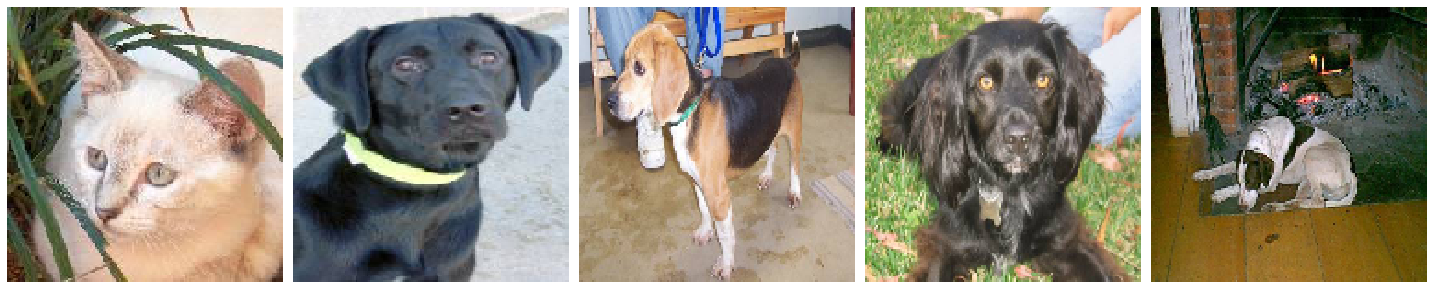

In [16]:
plotImages(sample_training_images[:5])

In [17]:
# 모델 만들기
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [18]:
# 모델 컴파일
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
# 요약
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [20]:
# 모델 훈련(fit_generator사용하여 ImageDataGenerator네트워크 훈련)
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15 steps, validate for 7 steps
Epoch 1/15
15/15 [==============================] - 22s 1s/step - loss: 0.9446 - accuracy: 0.5069 - val_loss: 0.6865 - val_accuracy: 0.5000
Epoch 2/15
15/15 [==============================] - 21s 1s/step - loss: 0.6906 - accuracy: 0.5246 - val_loss: 0.6797 - val_accuracy: 0.5078
Epoch 3/15
15/15 [==============================] - 21s 1s/step - loss: 0.6691 - accuracy: 0.5540 - val_loss: 0.6398 - val_accuracy: 0.5770
Epoch 4/15
15/15 [==============================] - 21s 1s/step - loss: 0.6315 - accuracy: 0.6004 - val_loss: 0.6162 - val_accuracy: 0.6038
Epoch 5/15
15/15 [==============================] - 21s 1s/step - loss: 0.5812 - accuracy: 0.6592 - val_loss: 0.5960 - val_accuracy: 0.6406
Epoch 6/15
15/15 [==============================] - 21s 1s/step - loss: 0.5389 - accuracy: 0.7046 - val_loss: 0.5965 - val_accuracy: 

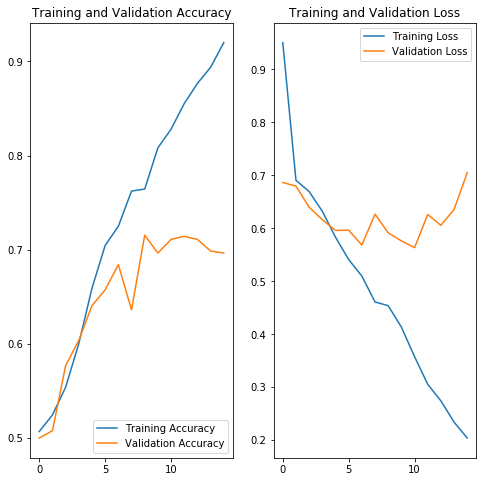

In [21]:
# 훈련 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
# 수평 뒤집기 적용
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [23]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 2000 images belonging to 2 classes.


In [24]:
#이미지를 무작위로 회전
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

In [25]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


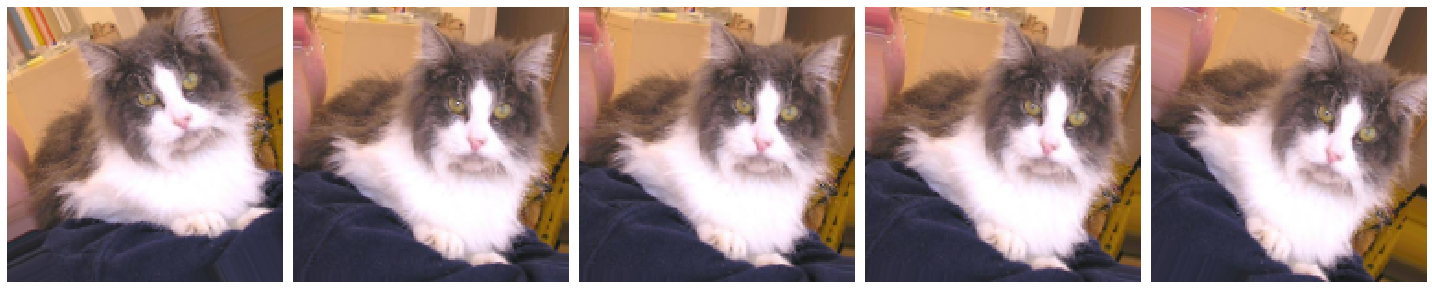

In [26]:
plotImages(augmented_images)

In [27]:
# 확대 확대 적용
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) # 

In [28]:
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


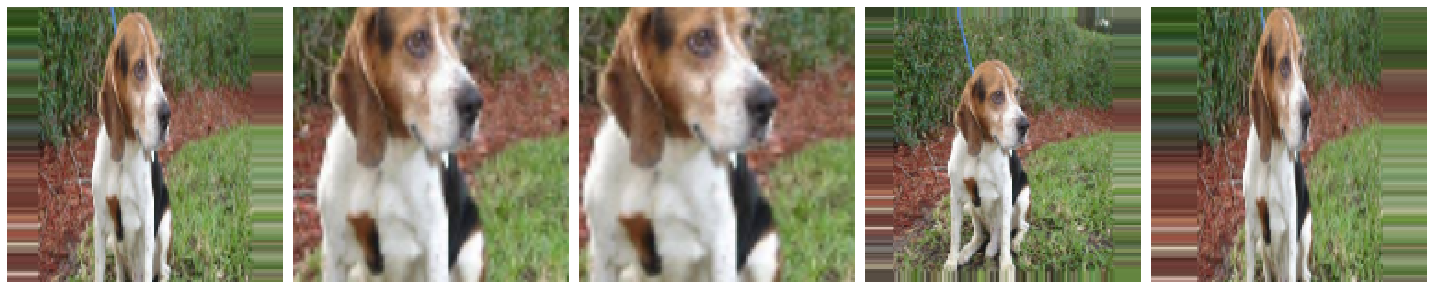

In [29]:
plotImages(augmented_images)

In [30]:
#모든 기능보강 적용
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [31]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


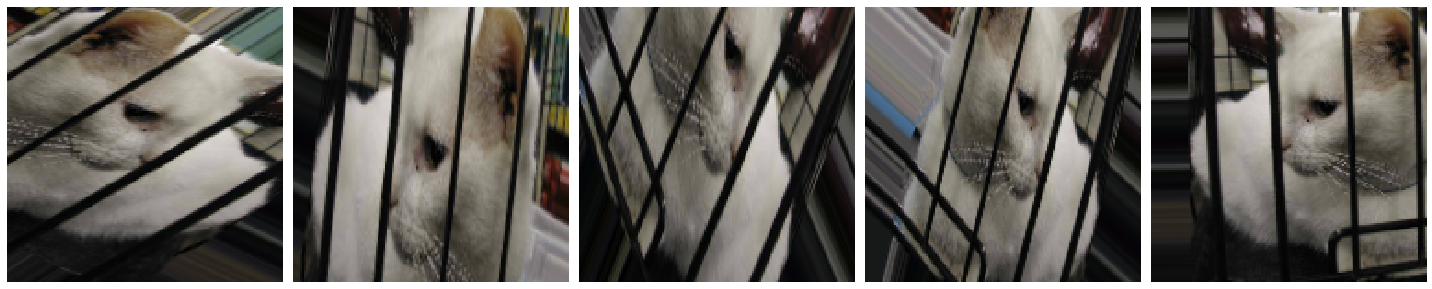

In [32]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [33]:
# 유효성 검사 데이터 생성기 만들기
image_gen_val = ImageDataGenerator(rescale=1./255)

In [34]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


In [35]:
# 드롭 아웃으로 새로운 네트워크 생성
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [36]:
# 모델 컴파일
model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 64)       

In [37]:
# 모델 훈련
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15 steps, validate for 7 steps
Epoch 1/15
15/15 [==============================] - 28s 2s/step - loss: 0.8744 - accuracy: 0.4984 - val_loss: 0.6922 - val_accuracy: 0.4900
Epoch 2/15
15/15 [==============================] - 27s 2s/step - loss: 0.6929 - accuracy: 0.4973 - val_loss: 0.6921 - val_accuracy: 0.4900
Epoch 3/15
15/15 [==============================] - 28s 2s/step - loss: 0.6896 - accuracy: 0.5026 - val_loss: 0.6836 - val_accuracy: 0.4900
Epoch 4/15
15/15 [==============================] - 27s 2s/step - loss: 0.6809 - accuracy: 0.5096 - val_loss: 0.6709 - val_accuracy: 0.5033
Epoch 5/15
15/15 [==============================] - 28s 2s/step - loss: 0.6703 - accuracy: 0.5443 - val_loss: 0.6626 - val_accuracy: 0.6105
Epoch 6/15
15/15 [==============================] - 26s 2s/step - loss: 0.6704 - accuracy: 0.5422 - val_loss: 0.6514 - val_accuracy: 0.5826
Epoch 7/15
15/15 [==============================] - 27s 2s/step - los

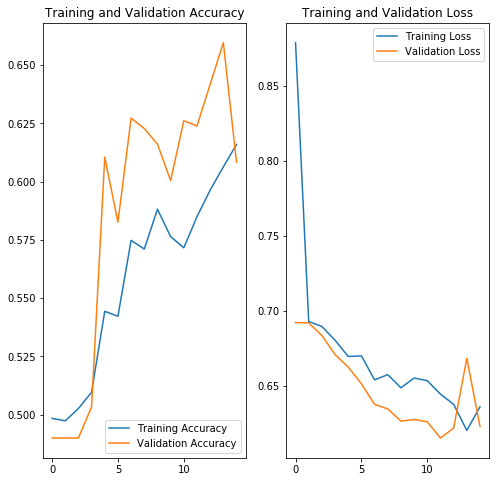

In [38]:
# 모델 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()